In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
compression_model_id = "jzlv54wl"

# Choose reference protein

In [8]:
import warnings
warnings.filterwarnings('ignore')

cath_id = "1jzdC00"
pdb_path = f"/homefs/home/lux70/storage/data/cath/dompdb/{cath_id}"

from plaid.utils import parse_sequence_from_structure

with open(pdb_path) as f:
    pdb_str = f.read()
    
sequence = parse_sequence_from_structure(pdb_str, cath_id)
print(len(sequence))
print(sequence)

from plaid.utils import view_py3Dmol
view_py3Dmol(pdb_str)

118
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Get embedding 

In [5]:
from plaid.esmfold import esmfold_v1
import torch

device = torch.device("cuda:0")
esmfold = esmfold_v1()
esmfold.to(device)

from plaid.compression.uncompress import UncompressContinuousLatent

hourglass_model = UncompressContinuousLatent(
    compression_model_id=compression_model_id,
    init_compress_mode=True
)
hourglass_model.to(device)

from plaid.proteins import LatentToSequence, LatentToStructure

latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure(esmfold=esmfold, delete_esm_lm=False)
latent_to_structure.to(device)


from plaid.utils import LatentScaler
scaler = LatentScaler()

Creating ESMFold...
ESMFold model loaded in 39.40 seconds.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
res = esmfold.infer_embedding(sequence)
x = res['s']
x = x.to(device)
print(x.shape)

x_norm = scaler.scale(x)
print(x_norm.shape)

x_compressed = hourglass_model.compress(x_norm)
print(x_compressed.shape)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(x_norm.squeeze().cpu().numpy(), ax=axs[0])
sns.heatmap(x_compressed.squeeze(), ax=axs[1])

# Diffusion Functions

In [ ]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def identity(t, *args, **kwargs):
    return t


def maybe_clip(x, clip_val):
    if clip_val is None:
        return x
    else:
        return torch.clamp(x, min=-1 * clip_val, max=clip_val)


def extract(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


def _forward_diffusion(beta_scheduler, timesteps, x_start, noise):
    betas = beta_scheduler(timesteps)
    betas = np.array(betas, dtype=np.float64)
    betas = betas
    assert len(betas.shape) == 1, "betas must be 1-D"
    assert (betas > 0).all() and (betas <= 1).all()
    
    num_timesteps = int(betas.shape[0])
    
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
    alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)
    assert alphas_cumprod_prev.shape == (num_timesteps,)
    
    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
    log_one_minus_alphas_cumprod = np.log(1.0 - alphas_cumprod)
    sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
    sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)
    
    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    # log calculation clipped because the posterior variance is 0 at the
    # beginning of the diffusion chain.
    posterior_log_variance_clipped = np.log(
        np.append(posterior_variance[1], posterior_variance[1:])
    )
    posterior_mean_coef1 = betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    posterior_mean_coef2 = (
        (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)
    )

    timesteps_ordered = torch.arange(0, timesteps).to(x_start.device)
    
    def q_sample(x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.
    
        In other words, sample from q(x_t | x_0).
    
        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    return q_sample(x_start, timesteps_ordered, noise)

# Noise Analysis

In [ ]:
from plaid.diffusion.beta_schedulers import make_beta_scheduler
from plaid.evaluation import run_tmalign
from plaid.utils import npy, calc_sequence_recovery
import pickle as pkl
from pathlib import Path
import einops
import numpy as np


def analysis(sched_name, x_start, n_timesteps, outdir, hourglass_model=None, scaler=None):
    # set up tensors
    assert x_start.shape[0] == 1
    noise = torch.randn_like(x_start)
    
    x_start = einops.repeat(x_start, "1 l c -> t l c", t=n_timesteps) 
    noise = einops.repeat(noise, "1 l c -> t l c", t=n_timesteps) 
    sequences = [sequence] * n_timesteps

    schedule = make_beta_scheduler(sched_name)

    # set up outdir
    outdir = Path(outdir)
    if not outdir.exists():
        outdir.mkdir(parents=True)
    
    # forward diffusion
    noised = _forward_diffusion(
        beta_scheduler=schedule,
        timesteps=n_timesteps,
        x_start=x_start,
        noise=noise
    )
    print("done diffusion.")
    print("noised shape:", noised.shape)

    # maybe need to uncompress and unscale too 
    if hourglass_model is not None:
        noised = hourglass_model.uncompress(noised)
        print("uncompressed shape:", noised.shape)

    if scaler is not None:
        noised = scaler.unscale(noised)
        print("unscaled shape:", noised.shape)

    # noised sequences
    noised_sequences = latent_to_sequence.to_sequence(noised)[-1]
    for i, s in enumerate(noised_sequences):
        if i % 10 == 0:
            print(s)

    with open(outdir/ "noised_sequences.fasta", "w") as f:
        for seq in noised_sequences:
            f.write(f"{seq}\n")
    
    seq_recovs = [calc_sequence_recovery(orig, noised) for orig, noised in zip(sequences, noised_sequences)]
    pkl.dump(seq_recovs, open(outdir / "sequence_recovery.pkl", "wb"))

    
    # noised structures
    res = latent_to_structure.to_structure(noised, sequences, batch_size=64)
    tm_scores = []
    
    for i, pdbstr in enumerate(res):
        fname = outdir / f"noised_{i}.pdb"
        with open(fname, "w") as f:
            f.write(pdbstr)
        tm_scores.append(run_tmalign(pdb_path, fname))
        
    pkl.dump(tm_scores, open(outdir / "tmscores.pkl", "wb"))


    # plot
    font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

    import matplotlib
    matplotlib.rc('font', **font)
    
    fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=120)
    
    axs[0].plot(seq_recovs)
    axs[0].set_title("Sequence Recovery")
    axs[0].set_xlabel("Forward Diffusion Timestep")
    axs[1].plot(tm_scores)
    axs[1].set_title("TM-Score")
    axs[1].set_xlabel("Forward Diffusion Timestep")
    
    plt.ylim(0,1)
    plt.show()
    fig.savefig(outdir / "plot.png")


In [ ]:
# analysis(
#     sched_name="adm_cosine",
#     x_start=x,
#     n_timesteps=500,
#     outdir = "/homefs/home/lux70/storage/plaid/artifacts/noise_schedule_figures/x_unnorm_t500/jzlv54wl",
#     hourglass_model=None,
#     scaler=None
# )

done diffusion.
noised shape: torch.Size([500, 118, 1024])
unscaled shape: torch.Size([500, 118, 1024])
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEF

(Generating structure): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [07:15<00:00, 54.48s/it]


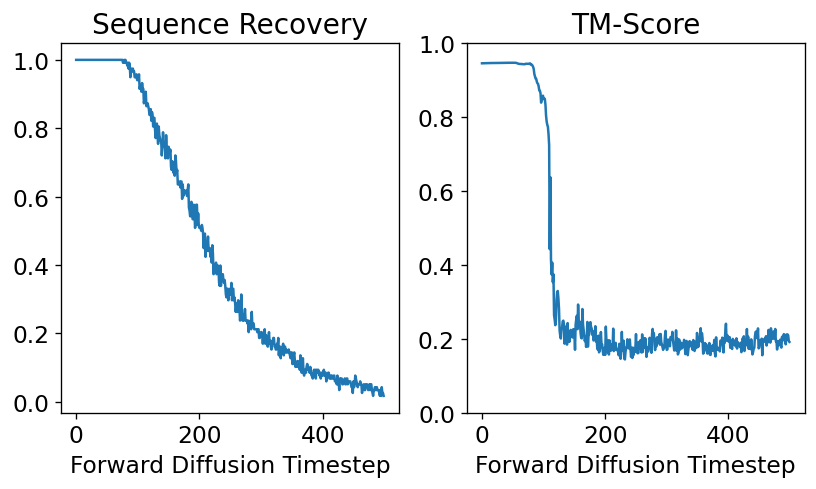

In [10]:
# analysis(
#     sched_name="adm_cosine",
#     x_start=x_norm,
#     n_timesteps=100,
#     outdir = "/homefs/home/lux70/storage/plaid/artifacts/noise_schedule_figures/x_norm_t500",
#     hourglass_model=None,
#     scaler=scaler
# )

In [ ]:
analysis(
    sched_name="adm_cosine",
    x_start=torch.from_numpy(x_compressed).to(device),
    n_timesteps=500,
    outdir = "/homefs/home/lux70/storage/plaid/artifacts/noise_schedule_figures/x_compressed_t500_jzlv54wl",
    hourglass_model=hourglass_model,
    scaler=scaler
)

In [ ]:
# interpolation

